# Importing Necessary Libraries

In [3]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random as rn


#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop,Adamax, Nadam
from keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

# Exploratory Data Analysis

In [4]:
pwd

'/kaggle/working'

In [5]:
import os
print(os.listdir('/kaggle/input/a-large-scale-fish-dataset'))

['NA_Fish_Dataset', 'Segmentation_example_script.m', 'README.txt', 'Fish_Dataset', 'license.txt']


In [6]:
directory = os.listdir('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

In [7]:
# Images' path
directory = '//kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

In [8]:
# Creating empty lists for image paths and labels
label = []
path = []

# Traversing the directories
for dir_name, _, filenames in os.walk(directory):
    for filename in filenames:
        # Processing only files with '.png' extension
        if os.path.splitext(filename)[-1] == '.png':
            # If not in the 'GT' (ground truth) folder, label it
            if dir_name.split()[-1] != 'GT':            
                label.append(os.path.split(dir_name)[-1])  # The folder name provides the label
                path.append(os.path.join(dir_name, filename))  # Save the file path

# Creating a DataFrame with the obtained image paths and labels
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path  # Adding the file paths
data['label'] = label  # Adding the labels

In [9]:
df = data

In [10]:
df.head(10)

path            label
0  //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
1  //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
2  //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
3  //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
4  //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
5  //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
6  //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
7  //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
8  //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
9  //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [12]:
df.isnull().sum()

path     0
label    0
dtype: int64

In [13]:
df.describe()  

path            label
count                                                9000             9000
unique                                               9000                9
top     //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
freq                                                    1             1000

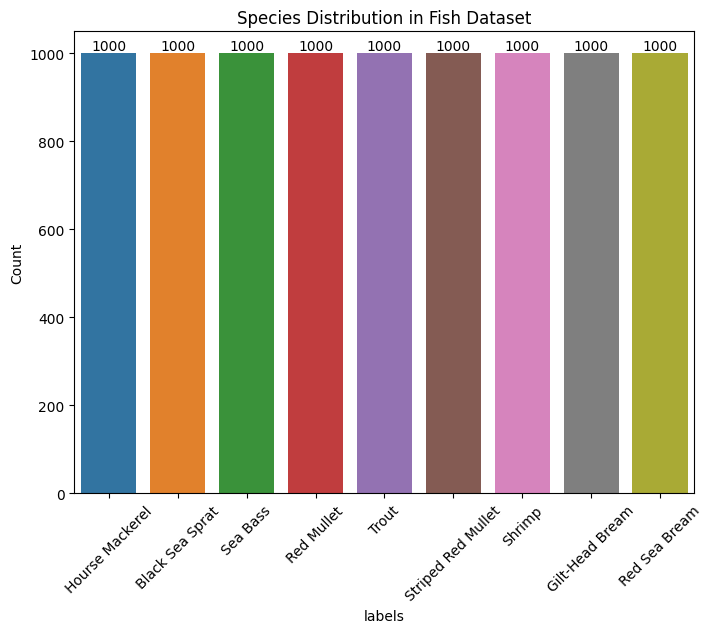

In [14]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='label')
ax.bar_label(ax.containers[0])
plt.title('Species Distribution in Fish Dataset')
plt.xlabel('labels')
plt.ylabel('Count')

# Rotate x-axis labels 45 degrees to the right
plt.xticks(rotation=45)

plt.show()


In [15]:
df.label.value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

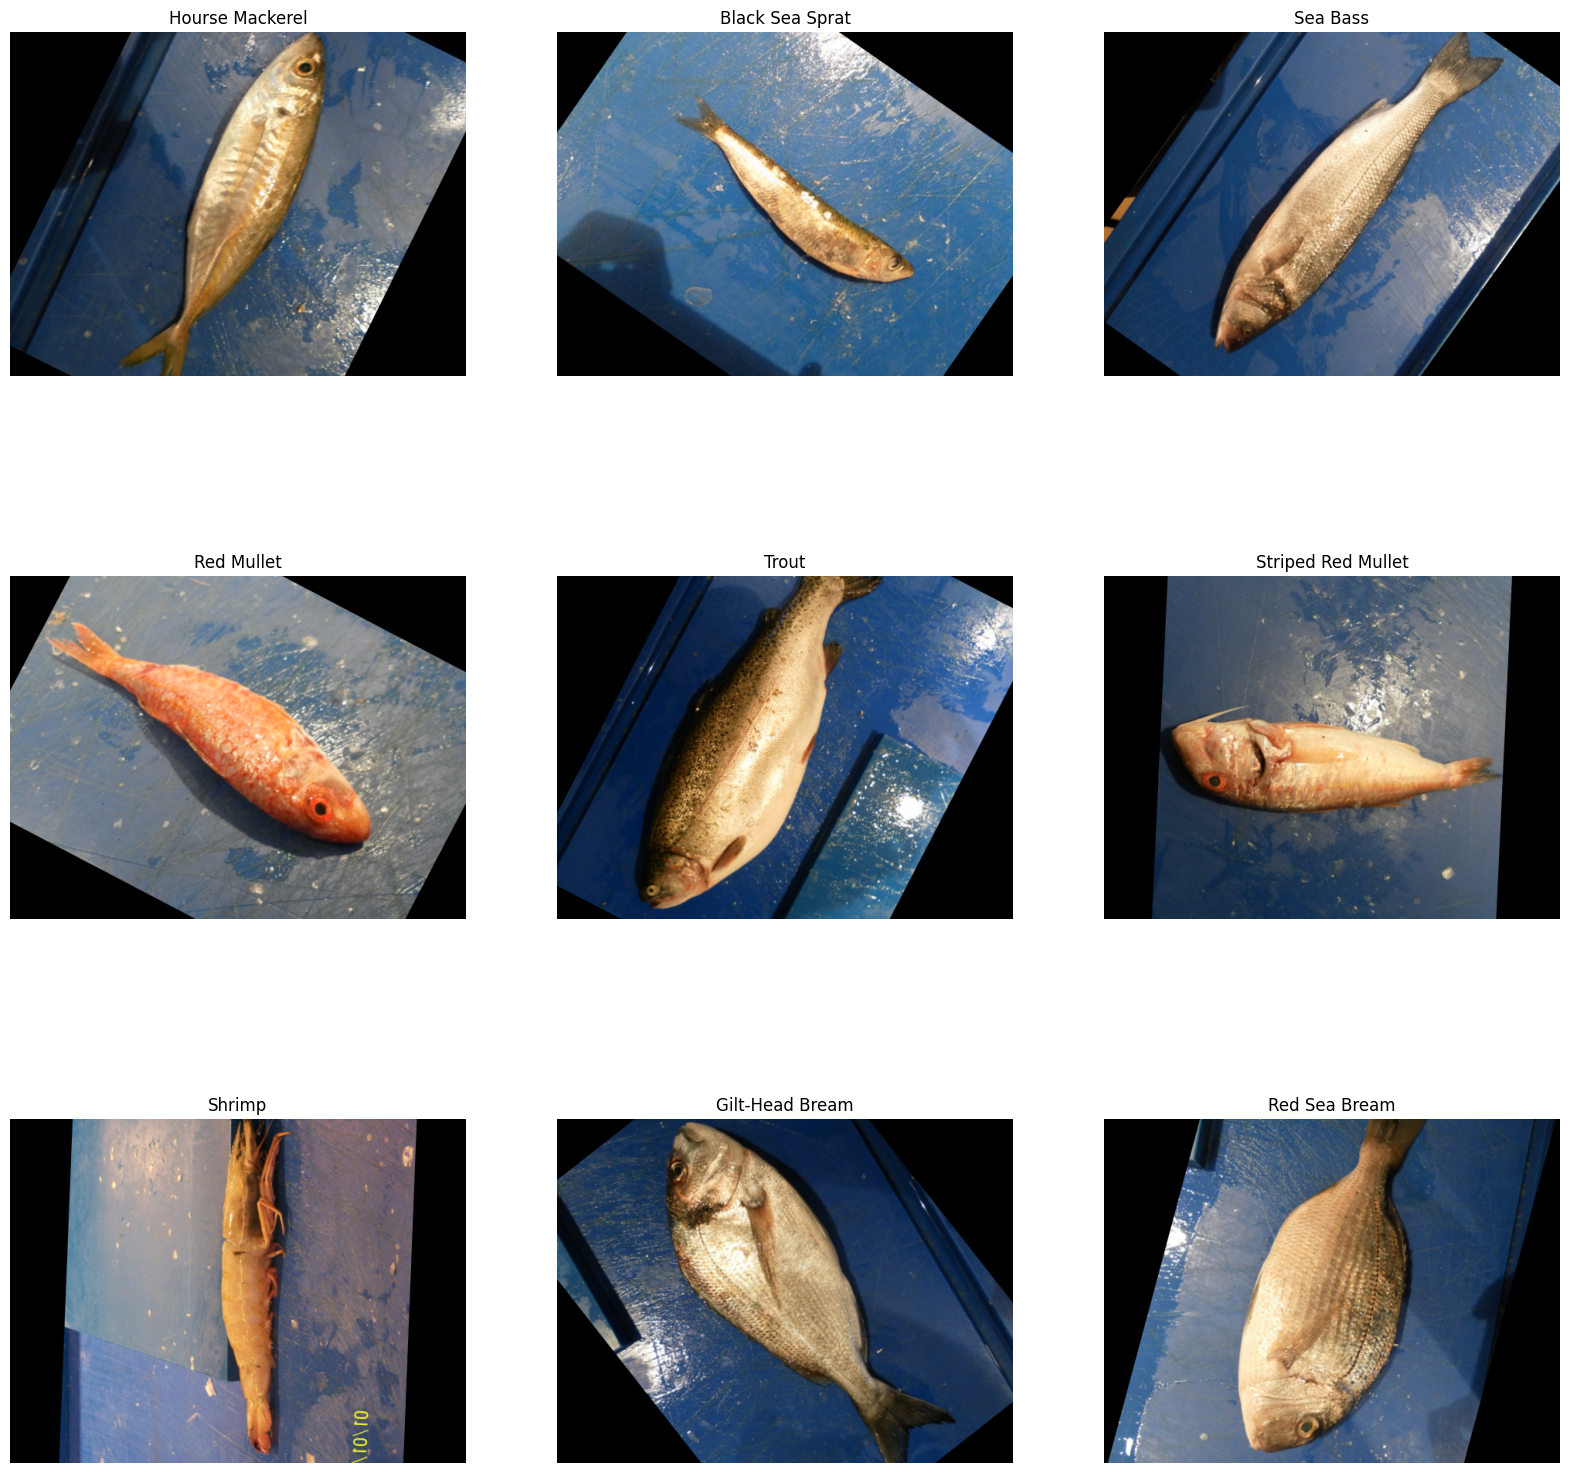

In [16]:
# Visualizing a few examples from each class
plt.figure(figsize=(20, 20))
for i, unique_label in enumerate(df['label'].unique()[:9]):  # Display the first 9 classes
    plt.subplot(3, 3, i+1)
    plt.imshow(plt.imread(df[df['label'] == unique_label].iloc[2, 0]))  # Load the 3rd image
    plt.title(unique_label)  # Add the class name
    plt.axis('off')
plt.show()

# Image Preprocessing

In [17]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Parameters
img_size = (128, 128)  # Resizing the images

# Function to preprocess the image
def preprocess_image(image_path, img_size):
    img = load_img(image_path, target_size=img_size)  # Load image
    img_array = img_to_array(img)  # Convert to array
    img_array = img_array / 255.0  # Normalize to [0,1]
    return img_array

# Preprocess all images
image_paths = df['path'].values
images = np.array([preprocess_image(path, img_size) for path in image_paths])

In [18]:
# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label'].values)

# One-hot encoding the labels
one_hot_labels = to_categorical(encoded_labels)

In [19]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, one_hot_labels, test_size=0.1, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (8100, 128, 128, 3)
Test data shape: (900, 128, 128, 3)


# Modeling

# model_1 ---> Simple Structure

We trained our model, model_1, using a simple architecture. Moving forward, we will decide on our next steps. From this point on, we will make adjustments to the model's architectural structure to improve its performance scores.

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Build the model
model = Sequential([
    Flatten(input_shape=(128, 128, 3)),  # Flatten 128x128x3 images into 1D arrays (49,152,)
    Dense(units=256, activation="relu"),  # First dense layer
    Dense(units=128, activation="relu"),  # Second dense layer
    Dense(units=64, activation="relu"),   # Third dense layer
    Dense(units=9, activation="softmax")  # Output layer with 9 neurons (for 9 classes)
])

# Compile the model with categorical crossentropy for one-hot encoded labels
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(x=X_train, y=y_train, 
                    validation_data=(X_test, y_test),
                    batch_size=32, epochs=50)

# Evaluate the model
score = model.evaluate(X_test, y_test)
print("Test accuracy:", score[1])


Epoch 1/50


I0000 00:00:1729788592.504507     124 service.cc:145] XLA service 0x7fe28c005010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729788592.504569     124 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729788592.504574     124 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 30/254 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1353 - loss: 10.3840

I0000 00:00:1729788594.239567     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


254/254 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3157 - loss: 4.1353 - val_accuracy: 0.6078 - val_loss: 1.1481
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6251 - loss: 1.1332 - val_accuracy: 0.7544 - val_loss: 0.7563
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7814 - loss: 0.6509 - val_accuracy: 0.7256 - val_loss: 0.7599
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8108 - loss: 0.5418 - val_accuracy: 0.7322 - val_loss: 0.6938
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8593 - loss: 0.4155 - val_accuracy: 0.7978 - val_loss: 0.6594
Epoch 6/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8851 - loss: 0.3374 - val_accuracy: 0.7500 - val_loss: 0.7999
Epoch 7/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8698 - loss: 0.4036 - val_accuracy: 0.7022 - val_loss: 0.9975
Epoch 8/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8894 - loss: 0.3144 - val_accuracy: 0.8756 - val

In [21]:
# Evaluate the model
score = model.evaluate(X_test, y_test)
print("Test accuracy:", score[1])
print("Test loss:", score[0])

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9597 - loss: 0.1845
Test accuracy: 0.9555555582046509
Test loss: 0.16586443781852722


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,874,717 (144.48 MB)

 Trainable params: 12,624,905 (48.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,249,812 (96.32 MB)

In [23]:
summary = pd.DataFrame(history.history)
summary.head()

accuracy      loss  val_accuracy  val_loss
0  0.449753  2.191536      0.607778  1.148073
1  0.685062  0.933038      0.754444  0.756298
2  0.775432  0.659003      0.725556  0.759872
3  0.815309  0.537068      0.732222  0.693850
4  0.854815  0.423605      0.797778  0.659418

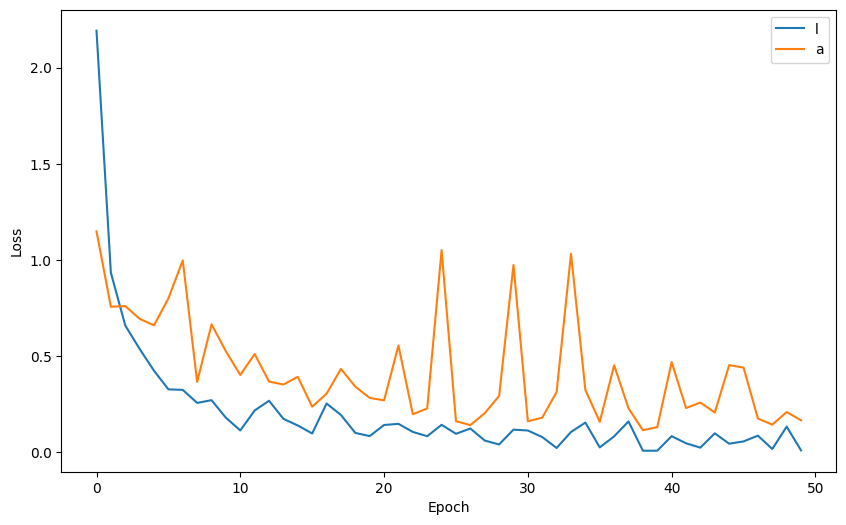

In [24]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss)              # DataFrame' den cekilen loss degerleri
plt.plot(summary.val_loss)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend('labels');

When we look at the graphs, we can see that even though our accuracy is high, the model makes significant errors in some areas.

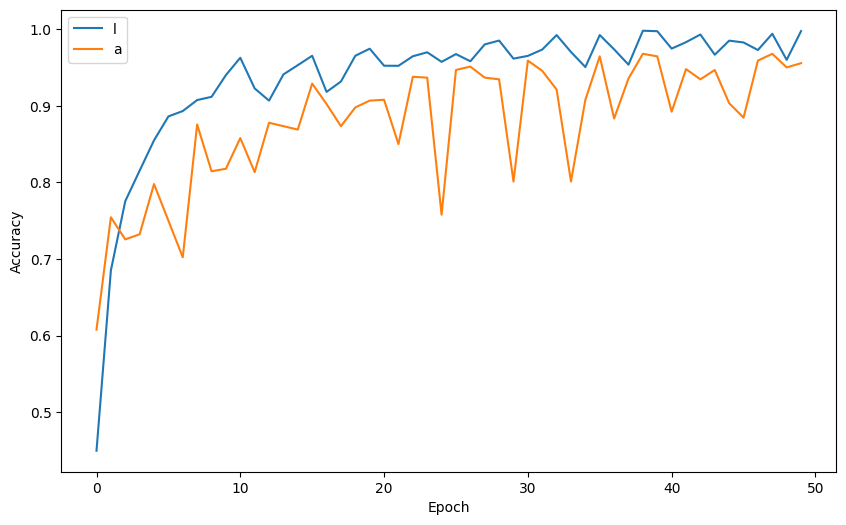

In [25]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy)        # DataFrame' den cekilen accuracy degerleri
plt.plot(summary.val_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend('labels');

In [26]:
preds = model.predict(X_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [27]:
predictions= np.argmax(preds, axis=1)

In [28]:
print(predictions[:300])

[1 0 2 8 8 4 7 4 3 8 3 7 3 6 1 3 8 4 4 3 6 7 1 1 7 2 1 6 2 8 2 6 0 0 2 2 6
 8 5 2 0 2 0 2 6 0 2 0 2 2 6 0 7 6 3 8 0 7 4 6 1 4 7 6 0 3 1 7 7 2 8 5 4 2
 8 0 0 0 7 5 0 3 5 2 7 4 4 6 4 0 2 1 0 1 6 8 0 6 2 5 0 8 8 1 5 5 6 6 7 1 5
 8 2 0 6 6 2 2 1 7 4 0 3 8 7 6 5 2 8 5 3 8 2 4 8 8 8 4 8 0 6 6 6 4 2 1 4 5
 3 6 0 1 3 4 0 6 1 1 3 0 5 2 4 2 0 0 2 3 3 1 4 1 0 6 5 0 0 8 4 2 3 7 8 0 5
 7 3 3 7 4 0 5 1 1 8 5 0 7 2 8 6 3 1 6 8 4 8 4 4 7 3 6 5 0 7 3 3 3 4 2 0 1
 0 2 7 8 6 5 0 4 2 5 5 0 4 5 3 8 8 0 1 8 4 3 1 2 3 3 8 5 2 2 8 4 5 5 1 7 2
 7 5 1 1 3 5 6 5 8 6 2 6 5 5 6 0 7 6 4 3 7 3 7 5 1 4 3 8 4 6 2 2 8 3 5 8 0
 6 6 5 6]


In [29]:
y_test_int = np.argmax(y_test, axis=1)

In [30]:
print(classification_report(y_test_int, predictions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       121
           1       0.99      0.85      0.92       108
           2       1.00      0.93      0.96        96
           3       0.98      1.00      0.99        79
           4       0.98      0.95      0.96        91
           5       0.84      0.99      0.91        99
           6       0.99      0.98      0.99       103
           7       0.97      0.98      0.98       100
           8       0.92      0.96      0.94       103

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900



In [31]:
print(confusion_matrix(y_test_int, predictions))

[[118   0   0   0   0   3   0   0   0]
 [  1  92   0   1   0   7   0   0   7]
 [  0   0  89   0   1   6   0   0   0]
 [  0   0   0  79   0   0   0   0   0]
 [  0   0   0   0  86   1   0   2   2]
 [  1   0   0   0   0  98   0   0   0]
 [  0   0   0   1   0   1 101   0   0]
 [  2   0   0   0   0   0   0  98   0]
 [  0   1   0   0   1   0   1   1  99]]


In [32]:
from tensorflow.keras.saving import save_model   # we saved this model to compare with other models later

save_model(model, 'model_1.keras')

In [33]:
# Evaluate the model
score = model.evaluate(X_test, y_test)
model_1_accuracy = score[1]

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9597 - loss: 0.1845


In [78]:
model_1_accuracy = 0.9597

# model_1.1 ---> with Dropout

In our model_1.1, we added a dropout layer to reduce overfitting. When we added it to multiple places, we observed that it significantly lowered the scores.

We also added learning rate and checkpoint into the callback.

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

model_11 = Sequential()

model_11.add(Flatten(input_shape=(128, 128, 3)))
model_11.add(Dense(128, activation='relu'))
model_11.add(Dense(64, activation='relu'))
model_11.add(Dropout(0.2, seed=42))
model_11.add(Dense(32, activation='relu'))
model_11.add(Dense(16, activation='relu'))
model_11.add(Dense(9, activation='softmax'))

optimizer = Adamax(learning_rate=0.001) 

model_11.compile(loss='categorical_crossentropy',
              optimizer=optimizer,              
              metrics=['accuracy'])

# Checkpoint; it will track val_loss and export the model when it's at the minimum, 
# deleting the previous one and saving the new one each time a lower loss is obtained.
checkpoint = ModelCheckpoint('model_11.keras', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# We are optimizing the learning rate;
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001) 
# Start with the initial learning rate, if val_loss does not decrease for 3 steps, multiply 
# the learning rate by the factor to reduce it and continue with the new learning rate.
# We specified to continue this process until the learning rate reaches a minimum of 0.0001.

early_stop = EarlyStopping(monitor='val_loss', patience=10)

batch_size=32

model_11.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,291,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,302,601 (24.04 MB)

 Trainable params: 6,302,601 (24.04 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model_11.fit(x=X_train, y=y_train, 
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size = batch_size,
                    verbose=1,
                    callbacks=[early_stop, checkpoint, reduce_lr])

Epoch 1/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1623 - loss: 2.6855
Epoch 1: val_loss improved from inf to 1.84686, saving model to model_11.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.1625 - loss: 2.6837 - val_accuracy: 0.3200 - val_loss: 1.8469 - learning_rate: 0.0010
Epoch 2/100
249/254 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3211 - loss: 1.8275
Epoch 2: val_loss improved from 1.84686 to 1.50133, saving model to model_11.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3218 - loss: 1.8259 - val_accuracy: 0.4633 - val_loss: 1.5013 - learning_rate: 0.0010
Epoch 3/100
252/254 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4134 - loss: 1.6052
Epoch 3: val_loss improved from 1.50133 to 1.25284, saving model to model_11.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4138 - loss: 1.6043 - val_accuracy: 0.5811 - val_loss: 1.2528 - learning_rate: 0.0010
Epoch 4/100
245/254 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.50

In [36]:
summary = pd.DataFrame(model_11.history.history)
summary.head()


accuracy      loss  val_accuracy  val_loss  learning_rate
0  0.214321  2.214928      0.320000  1.846863          0.001
1  0.351481  1.760652      0.463333  1.501334          0.001
2  0.444938  1.532978      0.581111  1.252838          0.001
3  0.536914  1.297518      0.636667  1.120384          0.001
4  0.607654  1.122621      0.705556  0.905150          0.001

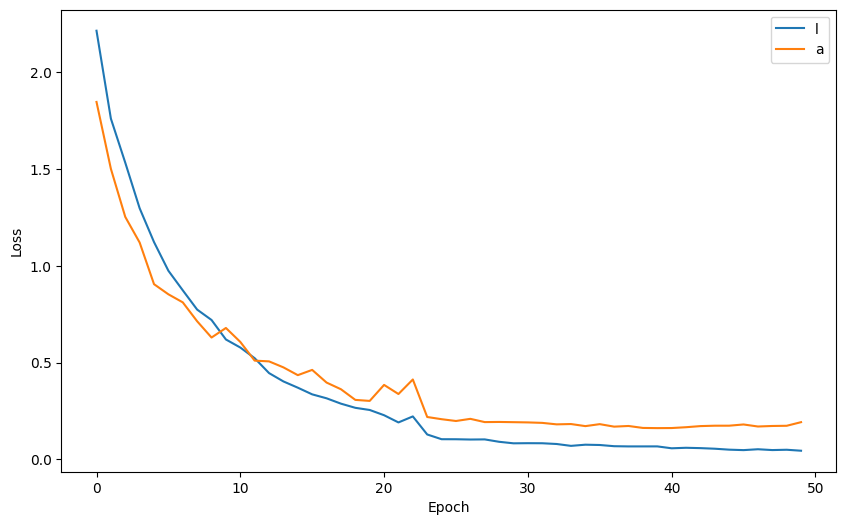

In [37]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss)          
plt.plot(summary.val_loss)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend('labels');

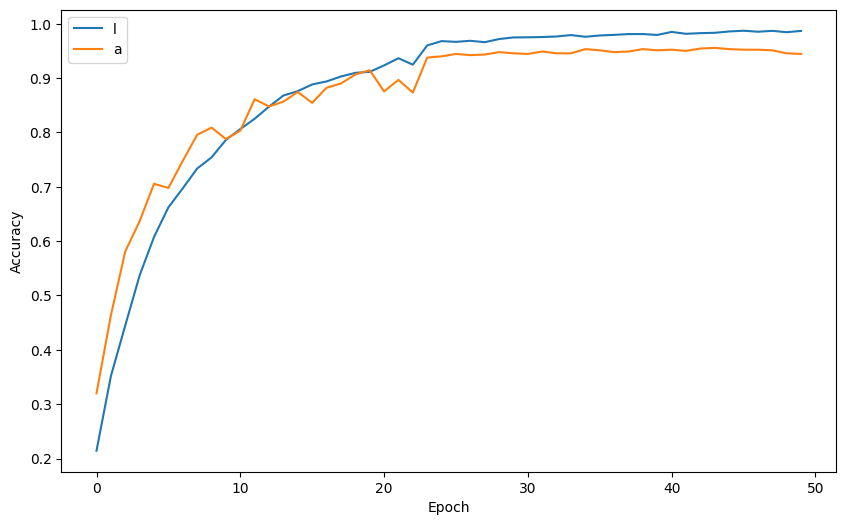

In [38]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy)        # DataFrame' den cekilen accuracy degerleri
plt.plot(summary.val_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend('labels');

Right now, our graphs look more stable and consistent.

In [39]:
# Evaluate the model
score = model_11.evaluate(X_test, y_test)
print("Test accuracy:", score[1])
print("Test loss:", score[0])

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9395 - loss: 0.2276
Test accuracy: 0.9444444179534912
Test loss: 0.19197431206703186


In [40]:
#save_model(model_11, 'model_11.keras')

In [79]:
# Evaluate the model
score = model_11.evaluate(X_test, y_test)
model_11_accuracy = score[1]

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9395 - loss: 0.2276


# model_2 ---> Using Image Generator

We trained our model_2 using an Image Generator and saved the results.

In [54]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 10%
                               height_shift_range=0.10, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

image_gen_scale = ImageDataGenerator(rescale=1/255)

In [55]:
np.random.seed(42)
tf.random.set_seed(42)
model = Sequential()

model.add(Flatten(input_shape=(128, 128, 3)))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3, seed=42))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2, seed=42))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2, seed=42))

model.add(Dense(9, activation='softmax'))

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     6,291,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,303,113 (24.04 MB)

 Trainable params: 6,302,665 (24.04 MB)

 Non-trainable params: 448 (1.75 KB)

In [56]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)

batch_size=32

# Assuming X_train and y_train are your image and label arrays
train_image_gen = image_gen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)

# Similarly for validation/test data
# Assuming X_test and y_test are your test image and label arrays
test_image_gen = image_gen_scale.flow(X_test, y_test, batch_size=batch_size, shuffle=False)


In [57]:
model_2 = model.fit(train_image_gen,epochs=200,
                    validation_data=test_image_gen,
                    batch_size = batch_size,
                    verbose= 1,
                    callbacks=[early_stop])

Epoch 1/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - accuracy: 0.1805 - loss: 2.4316 - val_accuracy: 0.1656 - val_loss: 2.1448
Epoch 2/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 36s 137ms/step - accuracy: 0.2786 - loss: 2.0129 - val_accuracy: 0.3878 - val_loss: 1.7583
Epoch 3/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 36s 137ms/step - accuracy: 0.3295 - loss: 1.8554 - val_accuracy: 0.4400 - val_loss: 1.5480
Epoch 4/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 36s 136ms/step - accuracy: 0.3513 - loss: 1.7500 - val_accuracy: 0.5000 - val_loss: 1.4146
Epoch 5/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - accuracy: 0.3766 - loss: 1.6819 - val_accuracy: 0.4967 - val_loss: 1.4095
Epoch 6/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 36s 136ms/step - accuracy: 0.3943 - loss: 1.6463 - val_accuracy: 0.4978 - val_loss: 1.4061
Epoch 7/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 36s 136ms/step - accuracy: 0.4126 - loss: 1.6058 - val_accuracy: 0.5211 - val_loss: 1.3140
Epoch 8/200
254/254 ━━━━━━━━━━━━━━━━━━━━ 36s 136ms/step - accuracy: 0.4237 -

In [58]:
save_model(model, 'model_2.keras')

In [59]:
summary = pd.DataFrame(model.history.history)
summary.tail(5)

accuracy      loss  val_accuracy  val_loss
86  0.641481  0.997676      0.775556  0.639057
87  0.630988  1.021604      0.747778  0.722633
88  0.641358  0.986072      0.777778  0.635462
89  0.639753  0.997127      0.756667  0.664711
90  0.640617  0.983350      0.774444  0.639434

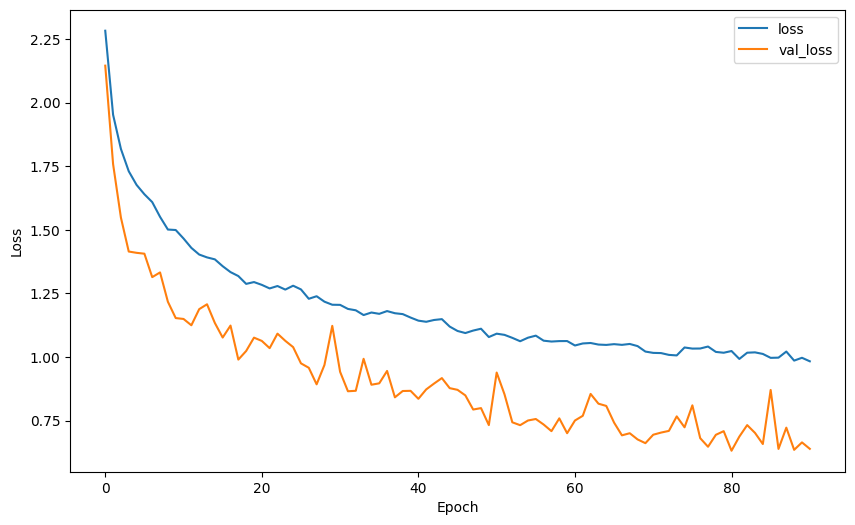

In [60]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label="loss")
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

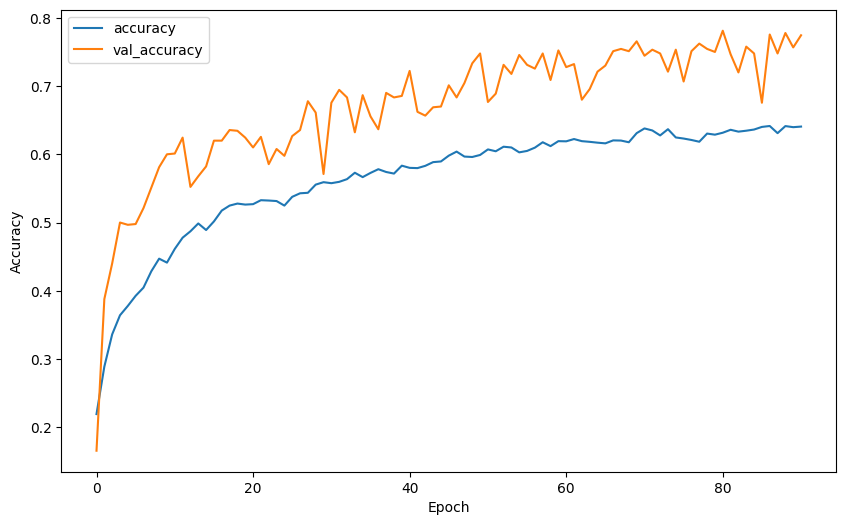

In [61]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [62]:
model.metrics_names

['loss', 'compile_metrics']

In [63]:
model.evaluate(test_image_gen)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7576 - loss: 0.6465


[0.639434278011322, 0.7744444608688354]

In [64]:
# Evaluate the model
score = model.evaluate(test_image_gen)
model_2_accuracy = score[1]

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7576 - loss: 0.6465


In [42]:
model_2_accuracy = 0.7576

# model_3   ---> Optimizer Adam

We observed that our scores did not improve with the Image Generator, so we are trying different optimizers with our original data.

In [43]:
np.random.seed(42)
tf.random.set_seed(42)
model = Sequential()

model.add(Flatten(input_shape=(128, 128, 3)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2, seed=42))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(9, activation='softmax'))

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 9)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,628,521 (48.17 MB)

 Trainable params: 12,628,329 (48.17 MB)

 Non-trainable params: 192 (768.00 B)

In [44]:
#Checkpoint; val los u takip edecek, min oldugu durumdaki modeli disa aktaracak, daha min los elde ettikce oncekini silip onu kaydedecek.
checkpoint = ModelCheckpoint('model_3.keras', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

#LR'i optimize ediyoruz;
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001) 
# baslangic lr ile basla, val_loss 3 adim boyunca dusmezse lr ile factor oranini carparak lr yi dusur 
# ve yola yeni lr ile devam et. Bu isleme lr min 0.0001 olana kadar devam et demis olduk.

early_stop = EarlyStopping(monitor='val_loss', patience=10)

batch_size=32

In [45]:
model_3 = model.fit(x=X_train, y=y_train, 
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size = batch_size,
                    verbose=1,
                    callbacks=[early_stop, checkpoint, reduce_lr])

Epoch 1/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2215 - loss: 2.0884
Epoch 1: val_loss improved from inf to 1.94000, saving model to model_3.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.2217 - loss: 2.0880 - val_accuracy: 0.2522 - val_loss: 1.9400 - learning_rate: 0.0010
Epoch 2/100
248/254 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4185 - loss: 1.6321
Epoch 2: val_loss did not improve from 1.94000
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4197 - loss: 1.6294 - val_accuracy: 0.2044 - val_loss: 3.0452 - learning_rate: 0.0010
Epoch 3/100
245/254 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5648 - loss: 1.2650
Epoch 3: val_loss did not improve from 1.94000
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5661 - loss: 1.2620 - val_accuracy: 0.2111 - val_loss: 4.1683 - learning_rate: 0.0010
Epoch 4/100
248/254 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6556 - loss: 1.0340
Epoch 4: val_loss did not improve from 1.94000
254/254

In [46]:
from tensorflow.keras.saving import save_model
save_model(model, 'model_3.keras')

In [47]:
summary = pd.DataFrame(model.history.history)
summary.tail()

accuracy      loss  val_accuracy  val_loss  learning_rate
37  0.990000  0.045383      0.918889  0.294012         0.0001
38  0.994074  0.038115      0.931111  0.272267         0.0001
39  0.992840  0.040582      0.894444  0.364175         0.0001
40  0.993086  0.040248      0.891111  0.338317         0.0001
41  0.992469  0.043307      0.936667  0.231136         0.0001

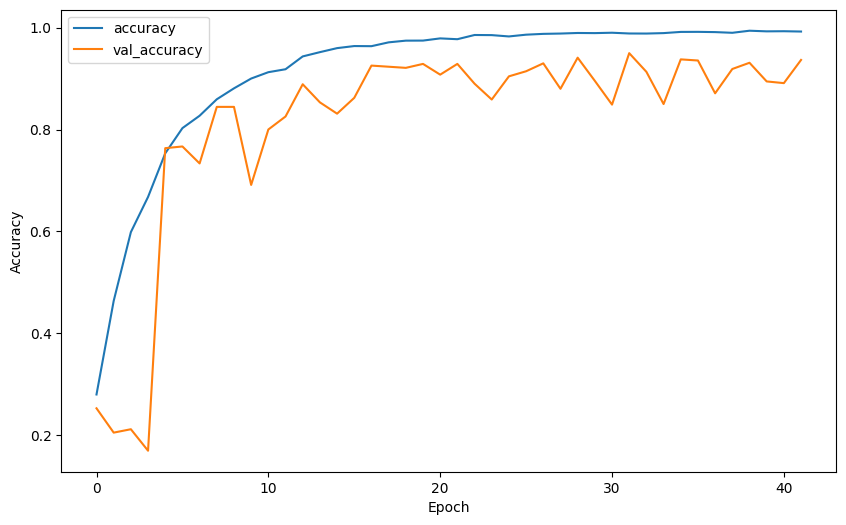

In [48]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [49]:
model.evaluate(X_test, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9322 - loss: 0.2288


[0.2311362475156784, 0.9366666674613953]

In [50]:
# Evaluate the model
score = model.evaluate(X_test, y_test)
model_3_accuracy = score[1]

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9322 - loss: 0.2288


# model_4   ---> Optimizer Nadam + IG

This time, we examined the scores using a different optimizer with the Image Generator.

In [76]:
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()

model.add(Flatten(input_shape=(128, 128, 3)))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3, seed=42))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1, seed=42))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))

model.add(Dense(9, activation='softmax'))



model.compile(Nadam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 9)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,627,657 (48.17 MB)

 Trainable params: 12,627,401 (48.17 MB)

 Non-trainable params: 256 (1.00 KB)

In [77]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define your callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_4.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train your model
model_4 = model.fit(train_image_gen,
                       epochs=50,
                       validation_data=test_image_gen,
                       batch_size=batch_size,
                       verbose=1,
                       callbacks=[early_stop, checkpoint, reduce_lr])

Epoch 1/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 47s 157ms/step - accuracy: 0.1440 - loss: 2.1822 - val_accuracy: 0.1844 - val_loss: 2.0699 - learning_rate: 0.0010
Epoch 2/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 37s 140ms/step - accuracy: 0.2086 - loss: 2.0179 - val_accuracy: 0.2144 - val_loss: 2.0135 - learning_rate: 0.0010
Epoch 3/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 36s 139ms/step - accuracy: 0.2691 - loss: 1.8853 - val_accuracy: 0.2700 - val_loss: 1.8596 - learning_rate: 0.0010
Epoch 4/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 37s 141ms/step - accuracy: 0.2972 - loss: 1.7959 - val_accuracy: 0.3944 - val_loss: 1.6181 - learning_rate: 0.0010
Epoch 5/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 37s 141ms/step - accuracy: 0.3252 - loss: 1.7454 - val_accuracy: 0.3744 - val_loss: 1.5682 - learning_rate: 0.0010
Epoch 6/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 36s 136ms/step - accuracy: 0.3450 - loss: 1.6779 - val_accuracy: 0.3422 - val_loss: 1.6300 - learning_rate: 0.0010
Epoch 7/50
254/254 ━━━━━━━━━━━━━━━━━━━━ 35s 136ms/step - accuracy: 0.3

In [79]:
summary = pd.DataFrame(model.history.history)
summary.tail()

accuracy      loss  val_accuracy  val_loss  learning_rate
9   0.376173  1.611841      0.407778  1.548131         0.0010
10  0.388272  1.578409      0.356667  1.727492         0.0010
11  0.396790  1.564397      0.388889  1.608322         0.0010
12  0.409506  1.520194      0.370000  1.643476         0.0002
13  0.411852  1.511306      0.344444  1.686401         0.0002

In [80]:
from tensorflow.keras.saving import save_model

save_model(model, 'model_4.keras')

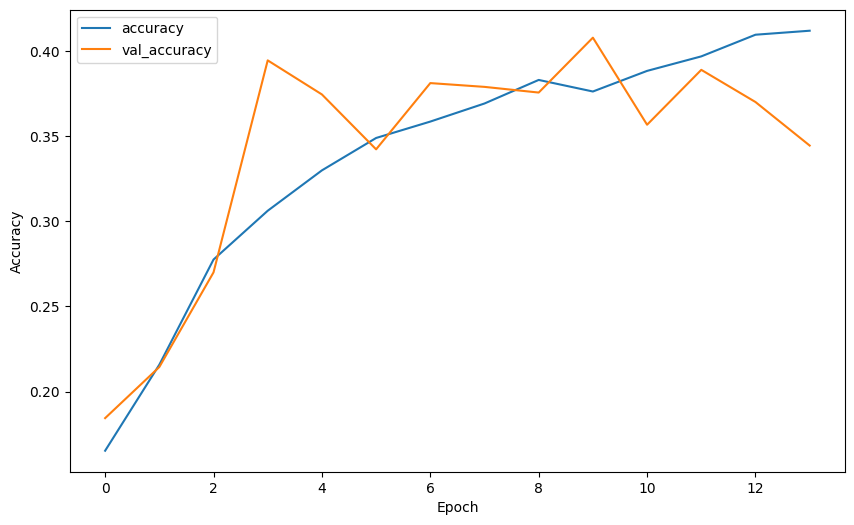

In [81]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [82]:
model.evaluate(test_image_gen)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3647 - loss: 1.5471


[1.5411425828933716, 0.37555554509162903]

In [83]:
# Evaluate the model
score = model.evaluate(test_image_gen)
model_4_accuracy = score[1]

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3647 - loss: 1.5471


In [73]:
model_4_accuracy = 0.3647

# model_5   --->Optimizer AdaGrad

In [51]:
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()

model.add(Flatten(input_shape=(128, 128, 3)))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3, seed=42))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1, seed=42))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))

model.add(Dense(9, activation='softmax'))

In [52]:
model.compile(Adagrad(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 9)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,627,657 (48.17 MB)

 Trainable params: 12,627,401 (48.17 MB)

 Non-trainable params: 256 (1.00 KB)

In [53]:
#Checkpoint; val los u takip edecek, min oldugu durumdaki modeli disa aktaracak, daha min los elde ettikce oncekini silip onu kaydedecek.
checkpoint = ModelCheckpoint('model_5.keras', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

In [54]:
# Define your callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_5.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

model_5 = model.fit(x=X_train, y=y_train, 
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size = batch_size,
                    verbose=1,
                    callbacks=[early_stop, checkpoint, reduce_lr])

Epoch 1/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.1219 - loss: 2.1931 - val_accuracy: 0.1889 - val_loss: 2.1371 - learning_rate: 0.0010
Epoch 2/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1477 - loss: 2.1440 - val_accuracy: 0.1233 - val_loss: 2.0971 - learning_rate: 0.0010
Epoch 3/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1769 - loss: 2.0644 - val_accuracy: 0.1878 - val_loss: 1.9829 - learning_rate: 0.0010
Epoch 4/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2265 - loss: 1.9923 - val_accuracy: 0.2267 - val_loss: 1.9495 - learning_rate: 0.0010
Epoch 5/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2512 - loss: 1.9426 - val_accuracy: 0.2856 - val_loss: 1.9526 - learning_rate: 0.0010
Epoch 6/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2841 - loss: 1.8975 - val_accuracy: 0.3122 - val_loss: 1.8233 - learning_rate: 0.0010
Epoch 7/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3133 - loss: 

In [55]:
summary = pd.DataFrame(model_5.history)
summary.tail()

accuracy      loss  val_accuracy  val_loss  learning_rate
86  0.819630  0.531924      0.857778  0.489329   8.000001e-06
87  0.825185  0.530232      0.858889  0.487846   1.600000e-06
88  0.817160  0.541774      0.858889  0.487674   1.600000e-06
89  0.828025  0.531786      0.857778  0.489521   1.600000e-06
90  0.820988  0.531490      0.857778  0.488302   1.000000e-06

In [56]:
save_model(model, 'model_5.keras')

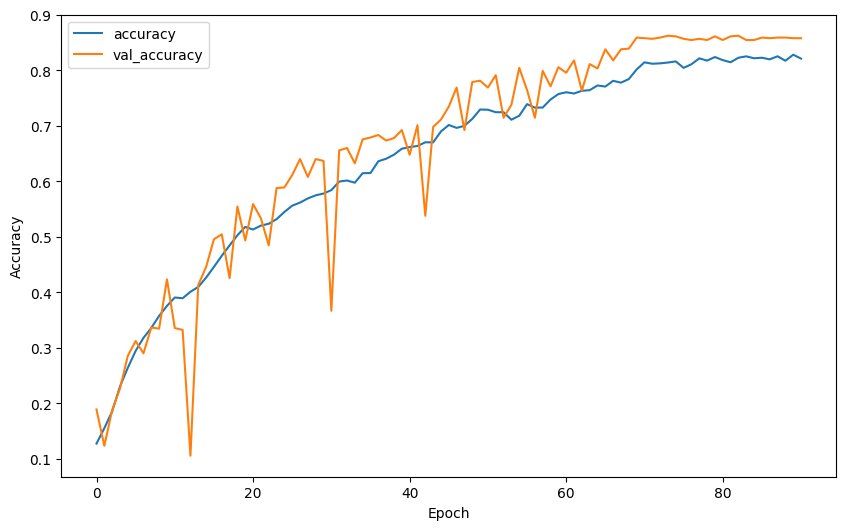

In [57]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [58]:
# Evaluate the model
score = model.evaluate(X_test, y_test)
model_5_accuracy = score[1]

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8643 - loss: 0.4655


# model_6  ---> Optimizer Adamax 

In [62]:
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()

model.add(Flatten(input_shape=(128, 128, 3)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3, seed=42))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2, seed=42))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(9, activation='softmax'))

optimizer = Adamax(learning_rate=0.001) 

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,              
              metrics=['accuracy'])

#Checkpoint; val los u takip edecek, min oldugu durumdaki modeli disa aktaracak, daha min los elde ettikce oncekini silip onu kaydedecek.
checkpoint = ModelCheckpoint('model_6.keras', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

#LR'i optimize ediyoruz;
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001) 
# baslangic lr ile basla, val_loss 3 adim boyunca dusmezse lr ile factor oranini carparak lr yi dusur 
# ve yola yeni lr ile devam et. Bu isleme lr min 0.0001 olana kadar devam et demis olduk.

early_stop = EarlyStopping(monitor='val_loss', patience=10)

batch_size=32

In [63]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 9)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,627,081 (48.17 MB)

 Trainable params: 12,627,081 (48.17 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Step 1: Train the model and store the history
history = model.fit(x=X_train, y=y_train, 
                       validation_data=(X_test, y_test),
                       epochs=100,
                       batch_size=batch_size,
                       verbose=1, 
                       callbacks=[early_stop, checkpoint, reduce_lr])

Epoch 1/100
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1208 - loss: 2.8919
Epoch 1: val_loss improved from inf to 2.18807, saving model to model_6.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.1208 - loss: 2.8900 - val_accuracy: 0.1733 - val_loss: 2.1881 - learning_rate: 0.0010
Epoch 2/100
248/254 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1297 - loss: 2.1807
Epoch 2: val_loss improved from 2.18807 to 2.12489, saving model to model_6.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1298 - loss: 2.1806 - val_accuracy: 0.1933 - val_loss: 2.1249 - learning_rate: 0.0010
Epoch 3/100
246/254 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1812 - loss: 2.1031
Epoch 3: val_loss improved from 2.12489 to 1.98786, saving model to model_6.keras
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1812 - loss: 2.1023 - val_accuracy: 0.2567 - val_loss: 1.9879 - learning_rate: 0.0010
Epoch 4/100
253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2039

In [67]:
summary = pd.DataFrame(model.history.history)
summary.tail()

accuracy      loss  val_accuracy  val_loss  learning_rate
91  0.753210  0.683219      0.800000  0.655716         0.0001
92  0.757654  0.673541      0.807778  0.639992         0.0001
93  0.753333  0.681119      0.795556  0.646859         0.0001
94  0.759383  0.673396      0.791111  0.660605         0.0001
95  0.756420  0.671593      0.784444  0.683424         0.0001

In [68]:
model.evaluate(X_test, y_test, verbose=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7583 - loss: 0.7252


[0.6834244132041931, 0.7844444513320923]

In [69]:
from tensorflow.keras.saving import save_model

save_model(model, 'model_6.keras')

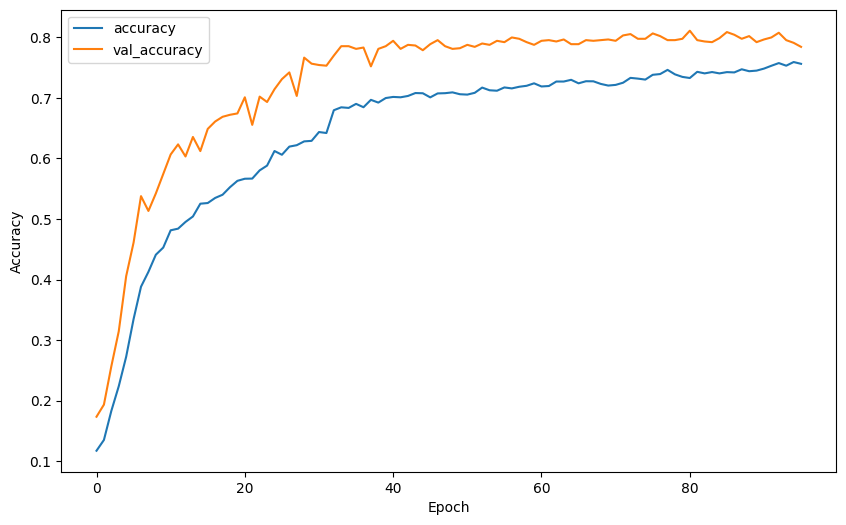

In [70]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [71]:
# Evaluate the model
score = model.evaluate(X_test, y_test)
model_6_accuracy = score[1]

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7583 - loss: 0.7252


# Model Comparing

We are comparing the accuracy values of the models we trained, and as a result, we can choose the architectural structure of our final model and train it with all our data.

In [80]:
# Step 1: Prepare the data
model_names = ['model_1', 'model_1.1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6']  # Replace with your actual model names
accuracy_values = [model_1_accuracy, model_11_accuracy, model_2_accuracy, model_3_accuracy, model_4_accuracy, model_5_accuracy,model_6_accuracy]  # Replace with accuracy values for each model


In [81]:
# Step 2: Create the DataFrame
data = {
    'Model Name': model_names,
    'Accuracy': accuracy_values,
}

df = pd.DataFrame(data)

In [84]:
# (Optional) Sorting the DataFrame by accuracy (best model first)
df_sorted = df.sort_values(by='Accuracy', ascending=False)
df_sorted

Model Name  Accuracy
0    model_1  0.959700
1  model_1.1  0.944444
3    model_3  0.936667
5    model_5  0.854444
6    model_6  0.784444
2    model_2  0.757600
4    model_4  0.364700

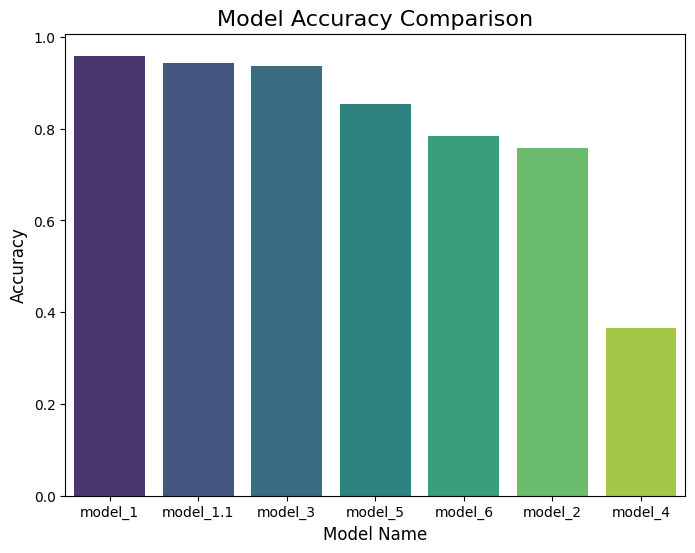

In [86]:
# Step 3: Plotting the bar graph
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed

# Using seaborn for better style
sns.barplot(x='Model Name', y='Accuracy', data=df_sorted, palette='viridis')

# Add labels and title
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Model Name', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Show the plot
plt.show()

# Final Model

In [88]:
# Build the model
model = Sequential([
    Flatten(input_shape=(128, 128, 3)),  # Flatten 128x128x3 images into 1D arrays (49,152,)
    Dense(units=256, activation="relu"),  # First dense layer
    Dense(units=128, activation="relu"),  # Second dense layer
    Dense(units=64, activation="relu"),   # Third dense layer
    Dense(units=9, activation="softmax")  # Output layer with 9 neurons (for 9 classes)
])

# Compile the model with categorical crossentropy for one-hot encoded labels
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(x=images, y=one_hot_labels,
                    batch_size=32, epochs=50)

# Evaluate the model
score = model.evaluate(X_test, y_test)
print("Test accuracy:", score[1])


Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.3040 - loss: 4.5558
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6624 - loss: 0.9644
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7565 - loss: 0.7033
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8225 - loss: 0.5175
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8522 - loss: 0.4163
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8923 - loss: 0.3093
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8877 - loss: 0.3335
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9015 - loss: 0.2836
Epoch 9/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9101 - loss: 0.2491
Epoch 10/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9262 - loss: 0.2039
Epoch 11/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9324 - loss: 0.1960
Epoch 12/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/ste

In [89]:
save_model(model, 'model_6.keras')

In [91]:
# Evaluate the model
score = model.evaluate(X_test, y_test)
score

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9923 - loss: 0.0226


[0.020861398428678513, 0.992222249507904]

# Test our model by comparing with original

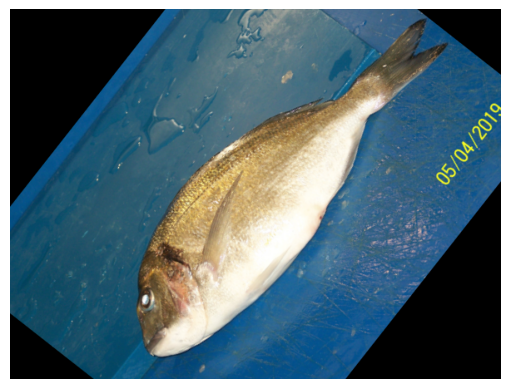

In [92]:
# Our original image from test folder
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Gilt-Head Bream/Gilt-Head Bream/00001.png'
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


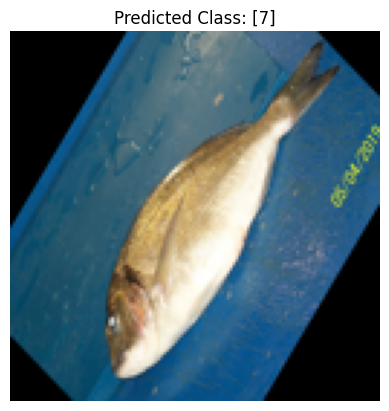

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Step 1: Load the saved model
model_path = 'final_model.keras'
final_model = load_model(model_path)

# Step 2: Load and preprocess the image
image_path = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Gilt-Head Bream/Gilt-Head Bream/00001.png'
image = Image.open(image_path)

# Resize the image to the input size expected by your model (e.g., 128x128)
image = image.resize((128, 128))

# Convert the image to a numpy array and expand dimensions to match model input
img = keras_image.img_to_array(image)
img = np.expand_dims(img, axis=0)  # Add batch dimension
img = preprocess_input(img)  # Apply model-specific preprocessing

# Step 3: Predict the class of the image
predictions = final_model.predict(img)

# Get the class with the highest probability (assuming softmax activation in the output layer)
predicted_class = np.argmax(predictions, axis=1)

# Step 4: Display the image with the predicted class
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.title(f"Predicted Class: {predicted_class}")  # Display the predicted class
plt.show()
